In [85]:
! pip install fbprophet pandas requests plotly tensorflow sklearn

  Using cached https://files.pythonhosted.org/packages/85/7a/ae480be23b768910a9327c33517ced4623ba88dc035f9ce0206657c353a9/scipy-1.4.1-cp37-cp37m-macosx_10_6_intel.whl
ERROR: pmdarima 1.7.1 has requirement numpy>=1.17.3, but you'll have numpy 1.17.2 which is incompatible.
ERROR: pmdarima 1.7.1 has requirement statsmodels<0.12,>=0.11, but you'll have statsmodels 0.10.1 which is incompatible.
  Found existing installation: scipy 1.3.1
    Uninstalling scipy-1.3.1:
      Successfully uninstalled scipy-1.3.1


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

from fbprophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
API_URL = 'https://api.coronavirus.data.gov.uk/v1/data?filters=areaType=nation;areaName=England&structure=%7B%22areaType%22:%22areaType%22,%22areaName%22:%22areaName%22,%22areaCode%22:%22areaCode%22,%22date%22:%22date%22,%22newCasesByPublishDate%22:%22newCasesByPublishDate%22,%22cumCasesByPublishDate%22:%22cumCasesByPublishDate%22%7D&format=json'

def pull_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()['data']
    print("Unable to fetch data")

data = pull_data(API_URL)
df = pd.DataFrame(data)
df.head()

,areaType,areaName,areaCode,date,newCasesByPublishDate,cumCasesByPublishDate
0,nation,England,E92000001,2020-10-01,5589,393931.0
1,nation,England,E92000001,2020-09-30,5656,388342.0
2,nation,England,E92000001,2020-09-29,5651,382686.0
3,nation,England,E92000001,2020-09-28,3316,377035.0
4,nation,England,E92000001,2020-09-27,4800,373719.0


In [3]:
df.info()
df['date']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 6 columns):
areaType                 273 non-null object
areaName                 273 non-null object
areaCode                 273 non-null object
date                     273 non-null object
newCasesByPublishDate    273 non-null int64
cumCasesByPublishDate    245 non-null float64
dtypes: float64(1), int64(1), object(4)
memory usage: 12.9+ KB


0      2020-10-01
1      2020-09-30
2      2020-09-29
3      2020-09-28
4      2020-09-27
          ...    
268    2020-01-07
269    2020-01-06
270    2020-01-05
271    2020-01-04
272    2020-01-03
Name: date, Length: 273, dtype: object

In [4]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()
# Drop the last row
# df = df[:-2]
df = df.tail(90)

In [5]:
df.head()
print(df)
print(df.shape)

           areaType areaName   areaCode  newCasesByPublishDate  \
date                                                             
2020-08-03   nation  England  E92000001                    856   
2020-08-04   nation  England  E92000001                    617   
2020-08-05   nation  England  E92000001                    804   
2020-08-06   nation  England  E92000001                    826   
2020-08-07   nation  England  E92000001                    796   
2020-08-08   nation  England  E92000001                    679   
2020-08-09   nation  England  E92000001                    988   
2020-08-10   nation  England  E92000001                    699   
2020-08-11   nation  England  E92000001                   1035   
2020-08-12   nation  England  E92000001                    925   
2020-08-13   nation  England  E92000001                   1059   
2020-08-14   nation  England  E92000001                   1284   
2020-08-15   nation  England  E92000001                    934   
2020-08-16

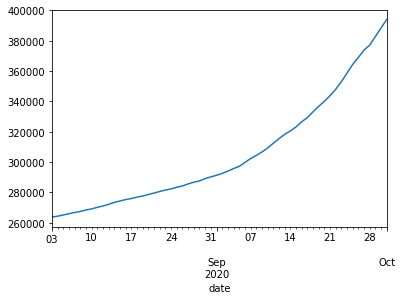

In [6]:
pd.plotting.register_matplotlib_converters()
df['cumCasesByPublishDate'].plot()

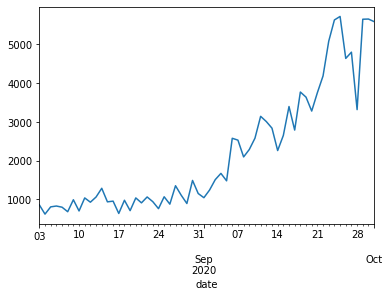

In [7]:
# TARGETCUMULATIVE = 'cumCasesBySpecimenDate'
# TARGETNEW = 'newCasesBySpecimenDate'
TARGET = 'newCasesByPublishDate'
# TARGET = 'cumCasesByPublishDate'

df[TARGET].plot()

In [8]:
# Number of days to predict
NUM_FUTURE_DAYS_PRED = 7

def get_train_test_split_data(df, test_percent=0.15):
    size = len(df)
    split_idx = int(size * (1 - test_percent))
    train_df = df[:split_idx]
    test_df = df[split_idx:]
    return train_df, test_df

daily_cases_score_table = pd.DataFrame(columns= ['mse_test'])
# cumulative_cases_score_table = pd.DataFrame(columns= ['r2_test','mse_test'])

# For plotting the results
def compute_result(algo, y_test, pred_test):
    
    # compute the performance
#     r2_test = r2_score(y_test, pred_test)
    mse_test = mean_squared_error(y_test, pred_test)
    
    # log the performance
    daily_cases_score_table.loc[algo,:] = mse_test
    
# # For plotting the results
# def compute_result2(algo, y_test, pred_test):

#     # compute the performance
#     r2_test = r2_score(y_test, pred_test)
#     mse_test = mean_squared_error(y_test, pred_test)
    
#     # log the performance
#     total_cases_score_table.loc[algo,:] = r2_test, mse_test

In [9]:
# Split by 15%
train_df, test_df = get_train_test_split_data(df, 0.15)
train_df.shape, test_df.shape

((51, 5), (9, 5))

In [10]:
scaler = MinMaxScaler()

scaler.fit(train_df[TARGET].values.reshape(-1, 1))
scaled_train_data = scaler.transform(train_df[TARGET].values.reshape(-1, 1))
scaled_test_data = scaler.transform(test_df[TARGET].values.reshape(-1, 1))

input_length = 2
num_features = 1

generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=input_length, batch_size=1)

lstm_model = Sequential()
lstm_model.add(LSTM(100, activation='relu', input_shape=(input_length, num_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
49/49 [==============================] - 0s 7ms/step - loss: 0.1192
Epoch 2/20
49/49 [==============================] - 0s 5ms/step - loss: 0.0486
Epoch 3/20
49/49 [==============================] - 0s 5ms/step - loss: 0.0291
Epoch 4/20
49/49 [==============================] - 0s 5ms/step - loss: 0.0216
Epoch 5/20
49/49 [==============================] - 0s 6ms/step - loss: 0.0146
Epoch 6/20
49/49 [==============================] - 0s 5ms/step - loss: 0.0116
Epoch 7/20
49/49 [==============================] - 0s 4ms/step - loss: 0.0126
Epoch 8/20
49/49 [==============================] - 0s 6ms/step - loss: 0.0124
Epoch 9/20
49/49 [==============================] - 0s 4ms/step - loss: 0.0117
Epoch 10/20
49/49 [==============================] - 0s 4ms/step - loss: 0.0115
Epoch 11/20
49/49 [==============================] - 0s 4ms/step - loss: 0.0111
Epoch 12/20
49/49 [==============================] - 

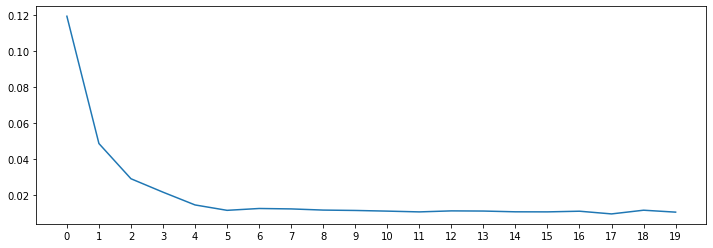

In [11]:
lstm_model.fit_generator(generator, epochs=20)

losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [12]:
lstm_predictions_scaled = list()
batch = scaled_train_data[-input_length:]
current_batch = batch.reshape((1, input_length, num_features))

for i in range(len(test_df)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)



lstm_model.save("model_lstm_test_new.h5")

In [13]:
compute_result('LSTM', test_df[TARGET], lstm_predictions)

print(daily_cases_score_table)

         mse_test
LSTM  3.41708e+06


In [14]:
# PROPHET_TARGET = 'cumCasesByPublishDate'
PROPHET_TARGET = 'newCasesByPublishDate'

def prepare_prophet_df(df):
    prophet_df = pd.DataFrame()
    prophet_df['ds'], prophet_df['y'] = df.index.to_series(), df[PROPHET_TARGET]
    return prophet_df

prophet_model = Prophet()
propeht_train_df = prepare_prophet_df(train_df)
propeht_test_df = prepare_prophet_df(test_df)
res = prophet_model.fit(propeht_train_df)
predictions = prophet_model.predict(propeht_test_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


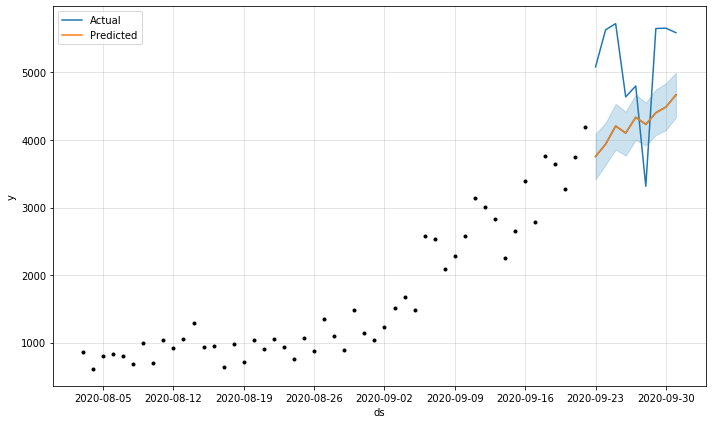

Daily cases score table: 
            mse_test
LSTM     3.41708e+06
Prophet  1.33672e+06


In [15]:
prophet_model.plot(predictions)

y_pred = predictions['yhat']
y_test = propeht_test_df['y']

plt.plot(test_df.index, y_test, label='Actual')
plt.plot(test_df.index, y_pred, label='Predicted')
plt.legend()
plt.show()


compute_result('Prophet', y_test, y_pred)

print('Daily cases score table: ')
print(daily_cases_score_table)


# print("Mean absolute percentage error: {}".format(mape(test_df[PROPHET_TARGET].values, y_pred)))
# print("MSE: {}".format(mean_squared_error(test_df[PROPHET_TARGET].values, y_pred)))

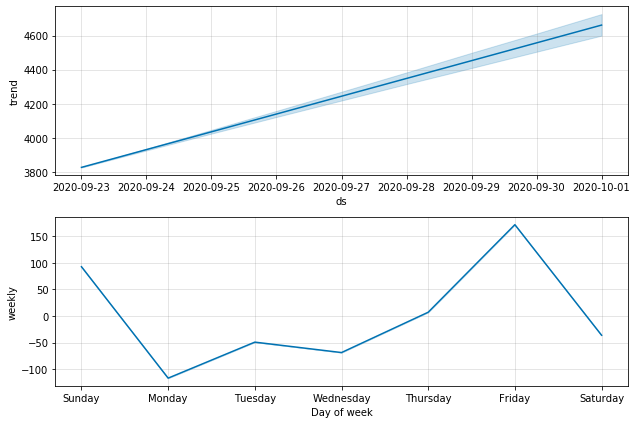

In [16]:
prophet_model.plot_components(predictions)
plt.show()

In [17]:
# Predictions from LSTM:

In [18]:
df[TARGET]

cases_so_far = df[-1:].cumCasesByPublishDate.values[0]
last_date = df[-1:].index.values[0]
cases_so_far, last_date

(393931.0, numpy.datetime64('2020-10-01T00:00:00.000000000'))

In [19]:
lstm_data = scaler.fit_transform(df[TARGET].values.reshape(-1, 1))
generator = TimeseriesGenerator(lstm_data, lstm_data, length=input_length, batch_size=1)
# lstm_model.fit_generator(generator, epochs=20)

from tensorflow.keras.models import load_model
lstm_model_loaded = load_model('model_lstm_test_new.h5')

lstm_predictions_scaled = []
batch = scaled_train_data[-input_length:]
current_batch = batch.reshape((1, input_length, num_features))

for i in range(NUM_FUTURE_DAYS_PRED):   
    lstm_pred = lstm_model_loaded.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_results = pd.DataFrame()
lstm_results['new_predicted'] = lstm_predictions.flatten().astype(int)
# lstm_results['new_predicted'] = lstm_results['total_predicted'].diff()
lstm_results['total_predicted'] = lstm_results['new_predicted'].cumsum() + cases_so_far
lstm_results.index = pd.date_range(start=last_date, periods=NUM_FUTURE_DAYS_PRED)
lstm_results

,new_predicted,total_predicted
2020-10-01,5844,399775.0
2020-10-02,6368,406143.0
2020-10-03,6709,412852.0
2020-10-04,7294,420146.0
2020-10-05,7869,428015.0
2020-10-06,8673,436688.0
2020-10-07,9629,446317.0


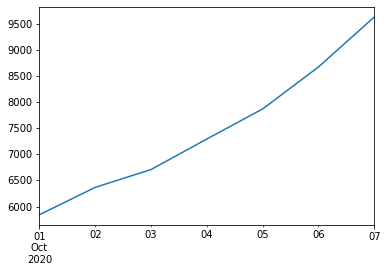

In [20]:
# New predicted cases using LSTM
lstm_results['new_predicted'].plot()

In [22]:
# Predictions from Prophet:

prophet_model = Prophet()

propeht_df = prepare_prophet_df(df)
prophet_model.fit(propeht_df)

future_df = prophet_model.make_future_dataframe(periods=NUM_FUTURE_DAYS_PRED, include_history=False)
future_preds = prophet_model.predict(future_df)
results = pd.DataFrame()
results['new_predicted'] = future_preds['yhat'].astype(int)
results['total_predicted'] = results['new_predicted'].cumsum() + cases_so_far
results.index = future_preds['ds']
results

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,new_predicted,total_predicted
ds,,
2020-10-02,5685,399616.0
2020-10-03,5478,405094.0
2020-10-04,5717,410811.0
2020-10-05,5498,416309.0
2020-10-06,5926,422235.0
2020-10-07,6164,428399.0
2020-10-08,6365,434764.0
